In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.random import normal
from tensorflow.keras.losses import BinaryCrossentropy

In [31]:
allowed_chars = 52
max_len = 450

def get_noize():
    return tf.random.normal(shape=(1,52,64))


def one_hot(smi):
    smi = "`" * (max_len - len(smi)) + smi
    encoded = [[0]*allowed_chars for _ in range(max_len)]
    for i, c in enumerate(smi):
        encoded[i][chars[c]] = 1
    return tf.transpose(tf.constant(encoded))

    
real_data = []
chars = set("`")
with open("smiles.smi") as f:
    for smiles in f:
        real_data.append(smiles[:-1])
        chars.update(smiles[:-1])
chars = sorted(chars)
chars = {c: i for i,c in enumerate(chars)}

real_data = [one_hot(smi) for smi in real_data]


In [32]:
def layer_bidir(units=40):
    fw = layers.GRU(units=units, return_sequences=True, go_backwards=False)
    bw = layers.GRU(units=units, return_sequences=True, go_backwards=True)
    bidir = layers.Bidirectional(layer=fw, backward_layer=bw)
    return bidir

def make_generator(dict_size=52, max_smi_len=450, lstm_units=40):
    model = Sequential()
    model.add(layers.Input(shape=(52,64)))
    model.add(layers.Dense(40))
    model.add(layer_bidir(lstm_units))
    model.add(layers.Dense(450, activation="softmax"))  
    return model

def make_discriminator():
    model = Sequential()
    model.add(layers.Input(shape=(52,450)))
    model.add(layers.Dense(40))
    model.add(layers.Dense(1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

cross_entropy = BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [33]:
generator = make_generator()
generator.build()
generator.summary(80)                

Model: "sequential_9"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_21 (Dense)                   (None, 52, 40)                  2600        
                                                                                
 bidirectional_7 (Bidirectional)    (None, 52, 80)                  19680       
                                                                                
 dense_22 (Dense)                   (None, 52, 450)                 36450       
                                                                                
Total params: 58,730
Trainable params: 58,730
Non-trainable params: 0
________________________________________________________________________________


In [34]:
discriminator = make_discriminator()
discriminator.build()
discriminator.summary(80)

Model: "sequential_10"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_23 (Dense)                   (None, 52, 40)                  18040       
                                                                                
 dense_24 (Dense)                   (None, 52, 1)                   41          
                                                                                
 flatten_5 (Flatten)                (None, 52)                      0           
                                                                                
 dense_25 (Dense)                   (None, 1)                       53          
                                                                                
Total params: 18,134
Trainable params: 18,134
Non-trainable params: 0
________________________________________________________________________________


In [40]:
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

Glosses = []
Dlosses = []

batch_size = 32

print("Starting Training Loop...")

num_epochs = 50
for epoch in range(num_epochs):
    print(f"epoch {epoch+1}/{num_epochs}")
    Glosses.append([])
    Dlosses.append([])
    
    for i in range(len(real_data) // batch_size):
        
        noize = tf.concat([get_noize() for _ in range(batch_size)], 0)
        data = tf.concat([real_data[i:i+batch_size]], 0)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_data = generator(noize, training=True)
                 
            fake_output = discriminator(fake_data, training=True)
            real_output = discriminator(data, training=True)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            Glosses[-1].append(gen_loss)
            Dlosses[-1].append(disc_loss)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print(f"  step {i}/{len(real_data)//batch_size}", end="; ")
        print(f"Dloss {Dlosses[-1][-1]}, Gloss {Glosses[-1][-1]}", end="\r")
    print(f"  step {i}/{len(real_data)//batch_size}", end="; ")
    print(f"Dloss {Dlosses[-1][-1]}, Gloss {Glosses[-1][-1]}")

        

Starting Training Loop...
epoch 1/50
  step 142/143; Dloss 0.9535051584243774, Gloss 0.5893564820289612
epoch 2/50
  step 142/143; Dloss 0.9274528622627258, Gloss 0.5530667304992676
epoch 3/50
  step 142/143; Dloss 0.9202947616577148, Gloss 0.5374366641044617
epoch 4/50
  step 142/143; Dloss 0.8768994212150574, Gloss 0.5589772462844849
epoch 5/50
  step 142/143; Dloss 0.8442327380180359, Gloss 0.5778838396072388
epoch 6/50
  step 142/143; Dloss 0.8182899355888367, Gloss 0.5945509076118469
epoch 7/50
  step 142/143; Dloss 0.8028721809387207, Gloss 0.6043747067451477
epoch 8/50
  step 142/143; Dloss 0.8165909051895142, Gloss 0.5911858081817627
epoch 9/50
  step 142/143; Dloss 0.7941814661026001, Gloss 0.6081315279006958
epoch 10/50
  step 142/143; Dloss 0.7709190249443054, Gloss 0.6268544197082528
epoch 11/50
  step 142/143; Dloss 0.7541495561599731, Gloss 0.6407279372215271
epoch 12/50
  step 142/143; Dloss 0.7714139819145203, Gloss 0.6246868371963501
epoch 13/50
  step 142/143; Dloss 0

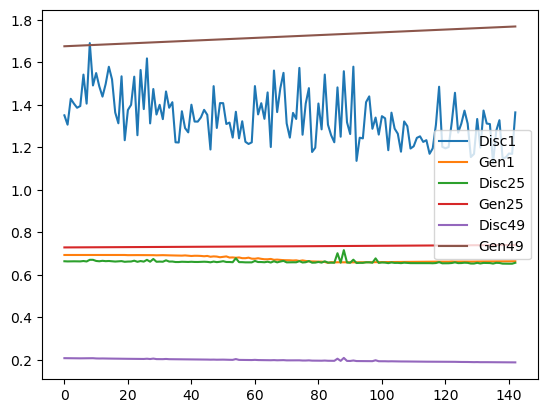

In [21]:
from matplotlib import pyplot as plt
import numpy as np

Dlosses = np.array(Dlosses)
Glosses = np.array(Glosses)

for i in range(0, num_epochs, 24):
    plt.plot(Dlosses[i], label=f"Disc{i+1}")
    plt.plot(Glosses[i], label=f"Gen{i+1}")
    
plt.legend()
plt.savefig("graph1.png")

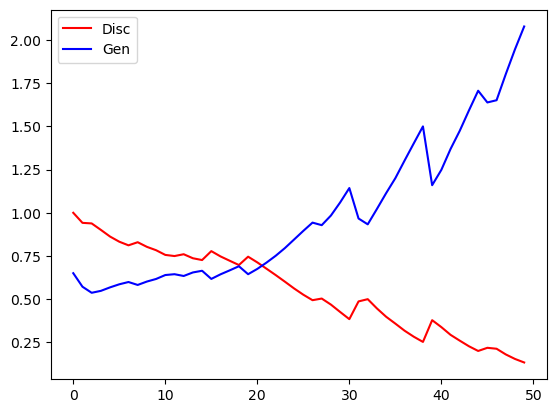

In [76]:
d_losses_means = [np.mean(i) for i in Dlosses]
g_losses_means = [np.mean(i) for i in Glosses]

plt.plot(d_losses_means, c="r")
plt.plot(g_losses_means, c="b")
plt.legend(["Disc", "Gen"])
plt.savefig("graph2.png")
plt.show()


In [89]:
chars_reversed = {v:k for k,v in chars.items()}

def interpret_generated(generator_out):
    smi = ''
    out = np.array(generator_out[0])
    for i in out.T:
        smi += chars_reversed[np.argmax(i)]
    return smi
    
    

In [90]:
noize = get_noize()
out = generator(noize, training=False)

interpret_generated(out)

'#########%i###s###########r##################################%#############n###############################################rs###################os#######s#######r############n#################################################################s##########################################n#########s##############################################r#######################################################################r#########s###########################'

In [48]:
real = "NCCCCC(CO)C=O"
real = "`" * (450-len(real)) + real
real = one_hot(real)
real = tf.expand_dims(real, 0)
real = discriminator(real)
real

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999461]], dtype=float32)>

In [49]:
discriminator.save("discriminator.wght")
generator.save("generator.wght")

INFO:tensorflow:Assets written to: discriminator.wght/assets


INFO:tensorflow:Assets written to: discriminator.wght/assets


INFO:tensorflow:Assets written to: generator.wght/assets


INFO:tensorflow:Assets written to: generator.wght/assets
